In [22]:
import numpy as np
print(np.__version__)

1.21.2


In [23]:
from scripts.CarSidePrediction import YoloModel

In [1]:
import numpy as np
import os, sys

ROOT_DIR = os.path.abspath("../../scripts")
sys.path.append(ROOT_DIR) 

# from DamagePrediction import *

In [25]:
# # import ssl
# # import certifi

# # urlopen(request, context=ssl.create_default_context(cafile=certifi.where()))


# import platform
# # ...

# ssl_context = ssl.SSLContext(ssl.PROTOCOL_TLS)
# ssl_context.verify_mode = ssl.CERT_REQUIRED
# ssl_context.check_hostname = True
# ssl_context.load_default_certs()

# if platform.system().lower() == 'darwin':
#     import certifi
#     ssl_context.load_verify_locations(
#         cafile=os.path.relpath(certifi.where()),
#         capath=None,
#         cadata=None)

# import urllib
# # previous context
# https_handler = urllib.request.HTTPSHandler(context=ssl_context)

# opener = urllib.request.build_opener(https_handler)
# # ret = opener.open(url, timeout=2)

In [2]:
# Loading image for demonstration
from PIL import Image
img = np.asarray(Image.open(f'{ROOT_DIR}/2.jpg'))

In [27]:
import cv2 as cv
import matplotlib.pyplot as plt

/Users/Daniel/anaconda3/envs/insurtech3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


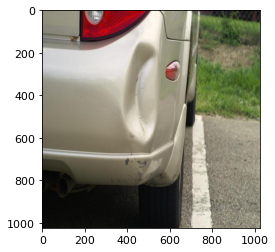

In [28]:
plt.imshow(img)
plt.show()

In [29]:
img2 = cv.rectangle(img, (200, 200), (600, 600), color=(1, 1, 1), thickness=-1)

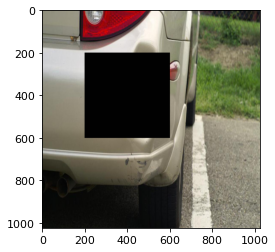

In [30]:
plt.imshow(img2)

In [31]:
height, width, _ = np.shape(img)

In [32]:
mask = np.zeros((height, width))
mask = cv.rectangle(mask, (200, 200), (600, 600), color=(1, 1), thickness=-1)

In [33]:
np.sum(mask)

160801.0

In [34]:
mask2 = np.zeros((height, width))
mask2 = cv.rectangle(mask2, (400, 400), (800, 800), color=(1, 1), thickness=-1)

In [35]:
combined = mask + mask2
intersect = np.where(combined == 2, 1, 0)
np.sum(intersect)

40401

In [36]:
np.sum(mask2)

160801.0

In [37]:
total_area_mask2 = np.sum(mask2)
intersect_area = np.sum(intersect) / total_area_mask2
intersect_area

0.251248437509717

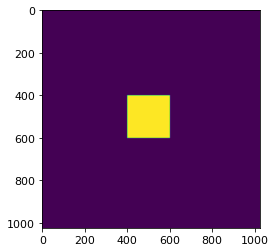

In [38]:
plt.imshow(intersect)

In [39]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = f"{ROOT_DIR}/best.pt", force_reload=True)
model.conf = 0.25
model.iou = 0.45

NameError: name 'torch' is not defined

In [ ]:
# # The (only) two lines needed
# model = YoloModel(f"{ROOT_DIR}/best.pt")

NameError: name 'YoloModel' is not defined

In [ ]:
results = model(img)

In [ ]:
coords = results.pandas().xyxy[0]

In [ ]:
coords

,xmin,ymin,xmax,ymax,confidence,class,name
0,0.0,49.639748,670.441467,833.315613,0.736232,0,Back


In [111]:
# Import Mask RCNN
ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR)  
# To find local version of the library
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.visualize import apply_mask, random_colors, display_instances
from mrcnn.utils import extract_bboxes, resize_image, resize
from skimage.measure import find_contours
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import tensorflow as tf
import io
import cv2
import copy

In [175]:
def get_array_from_plot(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        fig, ax = plt.subplots(1, figsize=figsize)
        fig.subplots_adjust(0,0,1,1,0,0)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    #ax.set_ylim(height + 10, -10)
    #ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.margins(0,0)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=30, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return data

# define the prediction configuration


class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "damage_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 2
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

def model_predict(image, model, cfg):
    class_names = ['BG', 'scratches', 'dents']
    # load image, bounding boxes and masks for the image id
    # image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    # Getting predicted values from r
    pred_class_id = r['class_ids']
    pred_mask = r['masks']
    pred_bbox = extract_bboxes(pred_mask)
    # display predicted image with masks and bounding boxes

    img_arr = get_array_from_plot(image, pred_bbox, pred_mask, pred_class_id, class_names , scores=r['scores'], title='Predicted')
    return img_arr, pred_class_id, pred_mask


def init_model():
    # create config
    cfg = PredictionConfig()
    # define the model
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    return cfg, model


def load_weights(model, path):
    # Loading the COCO weights
    model.load_weights(path, by_name=True)


def resize_image_array(img_arr):
    image, window, scale, padding, crop = resize_image(
        img_arr,
        min_dim=cfg.IMAGE_MIN_DIM,
        min_scale=cfg.IMAGE_MIN_SCALE,
        max_dim=cfg.IMAGE_MAX_DIM,
        mode=cfg.IMAGE_RESIZE_MODE)
    return image


In [ ]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# # tf.compat.v1.placeholder(shape=[None, 2], dtype=tf.float32)
# graph = tf.get_default_graph()
# cfg = PredictionConfig()
# # cfg, model = init_model()


In [42]:
graph = tf.get_default_graph()
cfg, model = init_model()
COCO_WEIGHTS_PATH = './Notebook/mask_rcnn_damage_0010.h5'
load_weights(model, COCO_WEIGHTS_PATH)

In [43]:
# Yolo model predict
yolo_model = YoloModel("./scripts/best.pt")

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /Users/Daniel/.cache/torch/hub/master.zip
YOLOv5 🚀 2021-10-16 torch 1.9.1 CPU

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients
Adding AutoShape... 


In [195]:
original, processed, coords = yolo_model.predict_single(img)

/Users/Daniel/anaconda3/envs/insurtech3/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


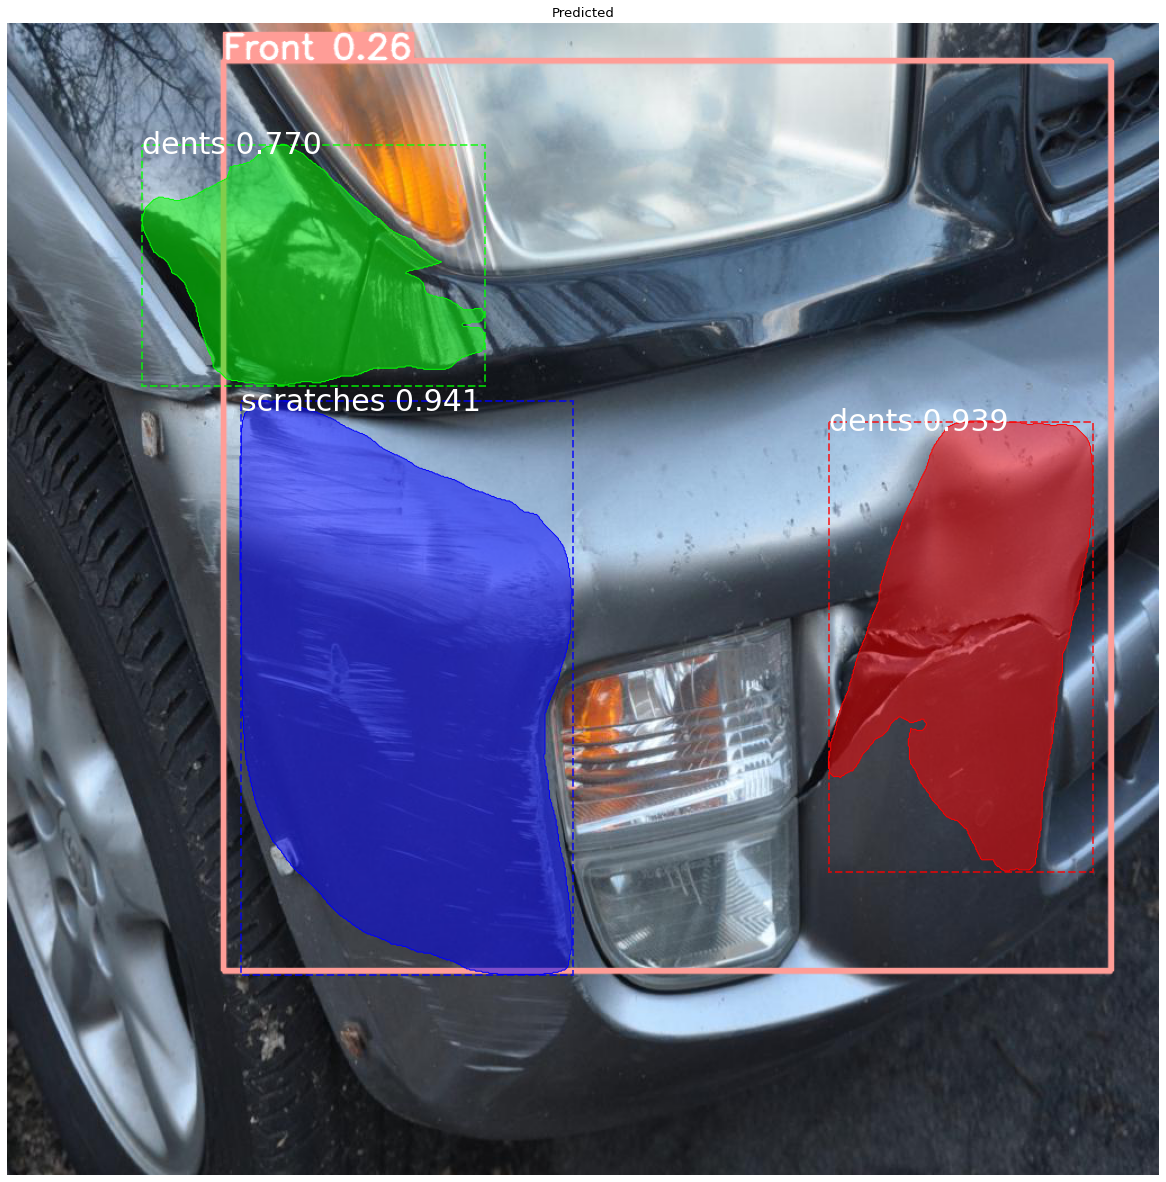

In [196]:
output,pred_class_id, damage_mask = model_predict(img ,model, cfg)

In [170]:
h,w = img.shape[:2]
print(h)
print(w)

1024
1024


In [171]:
coords

'[{"xmin":0.0,"ymin":49.6397476196,"xmax":670.4414672852,"ymax":833.315612793,"confidence":0.7362316847,"class":0,"name":"Back"}]'

In [178]:
# damage_mask


In [207]:
def cost_estimate(loc_coords, damage_mask, pred_class_id):
    location_mask = {}
    location_confidence = {}
    for loc in list(eval(loc_coords)):
        curr_name = loc["name"]
        curr_confidence = loc["confidence"]

        # print(loc["xmin"], loc["ymin"], loc["xmax"], loc["ymax"])
        # print(h, w)

        if curr_name not in location_confidence or location_confidence.get(curr_name) < curr_confidence:
            mask = np.zeros((h, w))

            xmin, ymin, xmax, ymax = tuple(map(lambda x: int(np.float32(x)),(loc["xmin"], loc["ymin"], loc["xmax"], loc["ymax"])))

            mask = cv.rectangle(mask, (xmin, ymin), (xmax, ymax), color=(1, 1, 1), thickness=-1)

            location_mask[curr_name] = mask
            location_confidence[curr_name] = curr_confidence

    location_with_damages = {} 

    for key, val in location_mask.items():
        location_with_damages[key] = []

    tracker = 0
    damage = ["BG", "Scratches", "Dents"]
    for damage_pred in pred_class_id:
        damage_name = damage[damage_pred]
        mask = np.copy(damage_mask[:, :, tracker])
        tracker += 1

        curr_area = np.count_nonzero(mask)
        # print(damage_name, curr_area)

        damage_loc = ""
        max_intersect_area = 0

        for location, mask2 in location_mask.items():
            combined = mask + mask2
            intersect = np.sum(np.where(combined==2, 1, 0))
            intersect_area = intersect / curr_area
            # print(location, intersect_area)
            if intersect_area > max_intersect_area or (max_intersect_area == 0 and intersect_area == 0):
                damage_loc = location
                max_intersect_area = intersect_area

        location_with_damages[damage_loc].append(damage_name)

    # print(location_with_damages)

    damage_to_cost = {
        "Scratches" : (200, 400),
        "Dents": (400, 1000)
    }

    total_cost = (0, 0)

    for key, val in location_with_damages.items():
        temp = max(list(map(lambda x: damage_to_cost[x], val)))
        total_cost = tuple(map(sum, zip(total_cost, temp)))

    total_cost = f"${total_cost[0]} - ${total_cost[1]}"
    return total_cost

In [208]:
cost_estimate(coords, damage_mask, pred_class_id)

'$400 - $1000'

In [186]:
tuple(map(sum, zip((1, 10),(2, 20))))

(3, 30)

In [200]:
max([(200, 400), (400, 1000), (400, 1000)])

(400, 1000)

In [ ]:
np.sum(mask)
mask2 = np.zeros((height, width))
mask2 = cv.rectangle(mask2, (400, 400), (800, 800), color=(1, 1), thickness=-1)
combined = mask + mask2
intersect = np.where(combined == 2, 1, 0)
np.sum(intersect)
np.sum(mask2)
total_area_mask2 = np.sum(mask2)
intersect_area = np.sum(intersect) / total_area_mask2
intersect_area

1152
1152
